# Predicting Errors in Satellite Imagery

Author: Simon Lachaîne
simonthechain@gmail.com

## Objective

Analyze various parameters recorded by a satellite alongside an image to determine which parameters are the most significant regarding the number of errors.

## Dataset

MOST-268_HD209458_2014-268_HD209458_2014: Data recorded by the MOST satellite (http://www.asc-csa.gc.ca/fra/satellites/most/default.asp)

## Initialization

In [1]:
import os
import tarfile

from astropy.visualization import astropy_mpl_style
from astropy.io import fits

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ipynb.fs.full.db_ops

In [23]:
plt.style.use(astropy_mpl_style)
%matplotlib inline

In [3]:
# database connection
engine = ipynb.fs.full.db_ops.get_engine()
session = ipynb.fs.full.db_ops.get_session()

## Ingesting Data

Included here for demonstration purposes, this will be implemented in a DAG through Airflow

In [4]:
# locate the dataset directory relative to this notebook
notebook_path = os.path.abspath("predict_errors.ipynb")
tar_dir = os.path.join(os.path.dirname(os.path.dirname(notebook_path)), "datasets/")

In [5]:
data = []

for root, dirs, files in os.walk(tar_dir):
    for f in files:
        if os.path.splitext(f)[1] == ".tar":
            
            # extract .tar file in memory
            with tarfile.open(
                name=os.path.join(root, f),
                mode="r"
            ) as tar_obj:
                
                # for every file in the tar file
                for member in tar_obj.getnames():
                    if os.path.splitext(member)[1] == ".fits":
                        extracted = tar_obj.extractfile(member)
                        
                        # open extracted .fits file
                        with fits.open(extracted) as hdul:
                            hdr = hdul[0].header
                            
                            data_dct = {
                                "filename": member,
                                "observer": hdr["OBSERVER"],
                                "target": hdr["TARGET"],
                                "exposure_date": hdr["DATE-OBS"],
                                "amplifier_value": hdr["OPAMP"],
                                "gain": hdr["GAIN"],
                                "magnetic_field": hdr["MAG_FLD"],
                                "heater_voltage": hdr["HEATER_V"],
                                "ccd_temp": hdr["T_CCD"],
                                "board_temp": hdr["T_BOARD"],
                                "preamp_temp": hdr["T_PREAMP"],
                                "errors": hdr["ERR_NUMB"],
                            }
                            data.append(data_dct)

In [6]:
# create a dataframe from the list of data dictionaries
df = pd.DataFrame(data)

# write the dataframe to the database
df.to_sql(
    name="SatStats",
    con=engine,
    if_exists="append",
    index=False,
)

## Loading Data

In [14]:
# predictor features
predictors = [
    "amplifier_value", 
    "gain", 
    "magnetic_field", 
    "ccd_temp", 
    "board_temp", 
    "preamp_temp",
]

# target feature
target = ["errors"]

In [32]:
columns = [
    "filename",
    "observer",
    "target",
    "exposure_date",
]
columns.extend(predictors)
columns.extend(target)

df = pd.read_sql(
    sql="SatStats",
    con=engine,
    parse_dates="exposure_date",
    columns=columns
)

## Data Preprocessing

In [33]:
# use readable column names
display_names = {
    "filename": "Filename",
    "observer": "Observer",
    "target": "Target",
    "exposure_date": "Exposure Date",
    "amplifier_value": "Amplifier Value",
    "gain": "Gain",
    "magnetic_field": "Magnetic Field Value",
    "heater_voltage": "Heater Voltage",
    "ccd_temp": "CCD Temperature",
    "board_temp": "Board Temperature",
    "preamp_temp": "Preamp Temperature",
    "errors": "Errors",
}
df.rename(columns=display_names, inplace=True)

In [34]:
# set exposure date as index
df.set_index(keys="Exposure Date", inplace=True)
df.sort_index(axis=0, inplace=True)

## Analysis

In [35]:
df.describe()

Amplifier Value    Gain  Magnetic Field Value  CCD Temperature  \
count           6708.0  6708.0           6708.000000      6708.000000   
mean               3.0     1.0          33183.963045       238.004417   
std                0.0     0.0           7281.736133         0.021845   
min                3.0     1.0          17019.006000       237.820000   
25%                3.0     1.0          26888.738000       238.002000   
50%                3.0     1.0          34994.234500       238.002000   
75%                3.0     1.0          39993.574750       238.023000   
max                3.0     1.0          44679.224000       238.164000   

       Board Temperature  Preamp Temperature       Errors  
count        6708.000000         6708.000000  6708.000000  
mean          301.974215          253.635064   120.281157  
std             0.605522            1.157169    19.820793  
min           300.415000          252.441000     2.000000  
25%           301.514000          253.052000   128.000000  
50%           302.002000          253.296000   128.000000  
75%           302.368000          253.540000   128.000000  
max           304.565000          257.080000   128.000000

## Line Plot

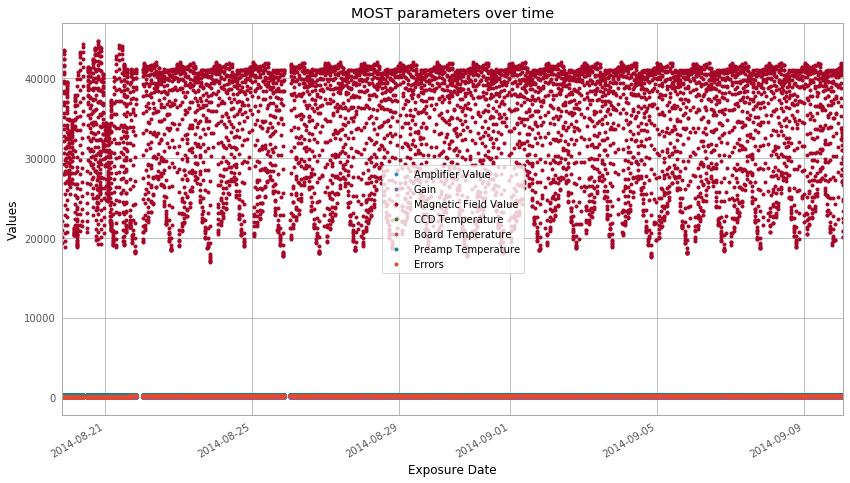

In [36]:
# df = df.loc[:, df.columns != "Magnetic Field Value"]
df.plot(kind="line", style=".", figsize=(14, 8))

plt.title("MOST parameters over time")
plt.xlabel("Exposure Date")
plt.ylabel("Values")

plt.show()